In [1]:
import sys
import os
import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk
from utils import utils
plt.style.use('ggplot')

In [2]:
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data

import torch
import PIL.ImageOps

In [3]:
available_device = "cuda" if torch.cuda.is_available() else "cpu"

#### Load dataset

In [4]:
transformations = [tfs.RandomAffine(0., scale=(0.5, 1.), fillcolor=0),
                   tfs.Resize((64, 64)),
                   tfs.Grayscale(1),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x))]

imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose(transformations))

data_loader = data.DataLoader(imagenet_data, batch_size=4, shuffle=True)

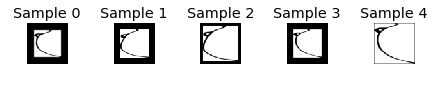

In [5]:
fig = plt.figure()

for i in range(len(imagenet_data)):
    sample = imagenet_data[i + 10]
    #print(sample)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    plt.imshow(np.asarray(sample[0]), cmap=plt.cm.gray_r)
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

#### Process type of vessels for classification

In [6]:
df = utils.create_df_from_files(path='data/perfiles_CATA/clases/')

#### Build and train classifier

In [7]:
imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose([tfs.RandomHorizontalFlip(p=0.7),
                                                           tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=0),
                                                           tfs.Resize((64, 64)),
                                                           tfs.Grayscale(1),
                                                           tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                                                           tfs.ToTensor(),
                                                           tfs.Normalize((0.5,), (0.5,))]))


In [8]:
splits_len = round(len(imagenet_data.samples)*0.2), round(len(imagenet_data.samples)*0.1), round(len(imagenet_data.samples)*0.7)

In [9]:
splits_len = splits_len if np.sum(splits_len) == len(imagenet_data.samples) else splits_len[0], splits_len[1], splits_len[2]+1

In [10]:
splits_len

(256, 128, 898)

#### Random split

In [11]:
splits = utils.random_split(imagenet_data, splits_len)

In [12]:
splits[0].dataset

Dataset ImageFolder
    Number of datapoints: 1282
    Root Location: data/perfiles_CATA/png_clasificados/
    Transforms (if any): Compose(
                             RandomHorizontalFlip(p=0.7)
                             RandomAffine(degrees=(0, 0), scale=(0.7, 1.0))
                             Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
                             Grayscale(num_output_channels=1)
                             Lambda()
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

In [13]:
splits[0].indices

tensor([1170,  835,  849,  628,  967,  717,  605,  306,  188,  551, 1107,   95,
        1256,  963, 1218,  933,  603,  813,  345,  206,  851,  649,  444,  340,
         255, 1075,  776,  791,   96,   50,  422,   60, 1250,  447, 1030,  174,
        1263,  528,  669,  608,  993,  909, 1164,  860,  904, 1083,  549,  350,
        1221,  659,  960,  412,  794,  117,   83, 1227,  332,  664, 1195,   94,
         679,  167,  579, 1279,  525,  151,  957, 1132,  118, 1138,  920,  385,
         309,  671,  723,  916,  986,  279,  883,  456,  819,   75,  411,  464,
        1150,   40,  360,   91,    0,  466,  749,  601, 1257,  651,   39,  745,
         147,  992,  358,  242,  798,  507, 1113,  379, 1042,  728,  328,  341,
        1192,  175,  509,  489,  157,  895, 1069,  337,  546, 1121,  186,  176,
         690,  185,  592,  533,   92,  273,  773,  825,  467, 1061,  228,  969,
         793, 1237,  418, 1149,  403, 1213,  848,  707,  194,   57, 1219,  695,
         607,  889, 1034, 1189,  346,  9

In [14]:
import pickle

In [15]:
filehandler = open("data_pickle/indice_0.pickle", 'wb') 
pickle.dump(splits[0].indices, filehandler)
filehandler = open("data_pickle/indice_1.pickle", 'wb') 
pickle.dump(splits[2].indices, filehandler)

In [16]:
file_pi2 = open('data_pickle/indice_0.pickle', 'rb') 
splits[0].indices = pickle.load(file_pi2)

file_pi2 = open('data_pickle/indice_1.pickle', 'rb') 
splits[2].indices = pickle.load(file_pi2)

In [17]:
train_loader = data.DataLoader(splits[2], batch_size=32, shuffle=True)
val_loader = data.DataLoader(splits[1], batch_size=32, shuffle=True)
test_loader = data.DataLoader(splits[0], batch_size=32, shuffle=True)

In [18]:
import torch.optim as optim
from torch import nn
from models.classifier import _C
import visdom
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import TopKCategoricalAccuracy, Loss
from ignite.handlers import ModelCheckpoint
import torch.nn.functional as F

In [19]:
C =_C(input_h_w=64)
C = C.to(available_device)
criterion = nn.CrossEntropyLoss().to(available_device)
C_optimizer = optim.Adam(C.parameters(), lr=0.0002, betas=(0.5, 0.999))

vis = visdom.Visdom(port='8090')
log_interval = 10
trainer = create_supervised_trainer(C, C_optimizer, F.cross_entropy, device=available_device)

handler_checkpoint = ModelCheckpoint('models/checkpoint_data', 'cnn_vessels', save_interval=2, n_saved=2, create_dir=True, require_empty=False, save_as_state_dict=True)
trainer.add_event_handler(Events.EPOCH_COMPLETED, handler_checkpoint, {'model': C, 'optimizer': C_optimizer})


evaluator = create_supervised_evaluator(C, metrics={'accuracy': TopKCategoricalAccuracy(),
                                                     'ce_ll': Loss(F.cross_entropy)},
                                           device=available_device)


train_avg_loss_window = utils.create_plot_window(vis, '#Iterations', 'Loss', 
                                                 'Training Average Loss')
train_avg_accuracy_window = utils.create_plot_window(vis, '#Iterations', 'Accuracy',
                                                     'Training Average Accuracy')
val_avg_loss_window = utils.create_plot_window(vis, '#Epochs', 'Loss',
                                               'Validation Average Loss')
val_avg_accuracy_window = utils.create_plot_window(vis, '#Epochs', 'Accuracy',
                                                   'Validation Average Accuracy')


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_nll = metrics['ce_ll']
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_nll))
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_accuracy]),
             win=train_avg_accuracy_window, update='append')
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_nll]),
             win=train_avg_loss_window, update='append')

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_nll = metrics['ce_ll']
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_nll))
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_accuracy]),
             win=val_avg_accuracy_window, update='append')
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_nll]),
             win=val_avg_loss_window, update='append')

trainer.run(train_loader, max_epochs=1000)

/home/pablo/miniconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training Results - Epoch: 1  Avg accuracy: 0.80 Avg loss: 2.34
Validation Results - Epoch: 1  Avg accuracy: 0.84 Avg loss: 2.32
Training Results - Epoch: 2  Avg accuracy: 0.88 Avg loss: 2.13
Validation Results - Epoch: 2  Avg accuracy: 0.92 Avg loss: 2.10
Training Results - Epoch: 3  Avg accuracy: 0.89 Avg loss: 1.88
Validation Results - Epoch: 3  Avg accuracy: 0.93 Avg loss: 1.86
Training Results - Epoch: 4  Avg accuracy: 0.89 Avg loss: 1.82
Validation Results - Epoch: 4  Avg accuracy: 0.89 Avg loss: 1.83
Training Results - Epoch: 5  Avg accuracy: 0.88 Avg loss: 1.80
Validation Results - Epoch: 5  Avg accuracy: 0.90 Avg loss: 1.79
Training Results - Epoch: 6  Avg accuracy: 0.89 Avg loss: 1.80
Validation Results - Epoch: 6  Avg accuracy: 0.90 Avg loss: 1.81
Training Results - Epoch: 7  Avg accuracy: 0.89 Avg loss: 1.78
Validation Results - Epoch: 7  Avg accuracy: 0.91 Avg loss: 1.80
Training Results - Epoch: 8  Avg accuracy: 0.88 Avg loss: 1.80
Validation Results - Epoch: 8  Avg accura

In [20]:
from torchsummary import summary
if available_device == "cuda":
    summary(C, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,088
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
       BatchNorm2d-4          [-1, 128, 16, 16]             256
              ReLU-5          [-1, 128, 16, 16]               0
            Linear-6                 [-1, 1024]      33,555,456
       BatchNorm1d-7                 [-1, 1024]           2,048
              ReLU-8                 [-1, 1024]               0
            Linear-9                   [-1, 11]          11,275
          Softmax-10                   [-1, 11]               0
Total params: 33,701,323
Trainable params: 33,701,323
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.77
Params size (MB): 128.56
Est

### Confusion matrix and classification report

In [21]:
import torchnet

confusion_window = utils.create_plot_window(vis, 'True Labels', 'Predicted', 'Confusion Matrix')

confusion_matrix = torchnet.meter.ConfusionMeter(11, normalized=True)
for ii, data_ in enumerate(test_loader):
    input_, label = data_
    val_input = Variable(input_).to(available_device)
    val_label = Variable(label.type(torch.LongTensor)).to(available_device)
    score = C(val_input)
    confusion_matrix.add(score.data.squeeze(), label.type(torch.LongTensor))
    
np.set_printoptions(precision=3)
print(confusion_matrix.value())
print(confusion_matrix.conf)
vis.heatmap(confusion_matrix.value(), win=confusion_window)

[[0.833 0.    0.    0.083 0.    0.    0.    0.    0.    0.083 0.   ]
 [0.    0.974 0.026 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.067 0.867 0.    0.    0.067 0.    0.    0.    0.    0.   ]
 [0.2   0.    0.    0.7   0.    0.    0.    0.    0.    0.1   0.   ]
 [0.    0.    0.    0.    0.647 0.    0.    0.    0.118 0.235 0.   ]
 [0.    0.    0.5   0.    0.    0.5   0.    0.    0.    0.    0.   ]
 [0.    0.    0.125 0.    0.    0.    0.875 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.2   0.7   0.    0.1   0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.013 0.    0.    0.    0.013 0.    0.974 0.   ]
 [0.    0.    0.    0.    0.2   0.    0.    0.    0.    0.    0.8  ]]
[[10  0  0  1  0  0  0  0  0  1  0]
 [ 0 75  2  0  0  0  0  0  0  0  0]
 [ 0  2 26  0  0  2  0  0  0  0  0]
 [ 2  0  0  7  0  0  0  0  0  1  0]
 [ 0  0  0  0 11  0  0  0  2  4  0]
 [ 0  0  1  0  0  1  0  0  0  0  0]
 [ 0  0  1  0  0  0  7  

'window_37cb7ec1465eec'

In [22]:
from sklearn import metrics

def iterations_test(C, test_loader):
    y_real = list()
    y_pred = list()

    for ii, data_ in enumerate(test_loader):
        input_, label = data_
        val_input = Variable(input_).to(available_device)
        val_label = Variable(label.type(torch.LongTensor)).to(available_device)
        score = C(val_input)
        _, y_pred_batch = torch.max(score, 1)
        y_pred_batch = y_pred_batch.cpu().squeeze().numpy()
        y_real_batch = val_label.cpu().data.squeeze().numpy()
        y_real.append(y_real_batch.tolist())
        y_pred.append(y_pred_batch.tolist())

    y_real = [item for batch in y_real for item in batch]
    y_pred = [item for batch in y_pred for item in batch]
    
    return y_real, y_pred

In [23]:
y_real, y_pred = iterations_test(C, test_loader)
print(metrics.classification_report(np.array(y_pred), np.array(y_real)))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.97      0.97      0.97        77
           2       0.87      0.93      0.90        28
           3       0.70      0.78      0.74         9
           4       0.76      0.93      0.84        14
           5       0.50      0.33      0.40         3
           6       0.75      0.86      0.80         7
           7       0.80      0.80      0.80        10
           8       0.89      0.67      0.76        12
           9       0.96      0.90      0.93        81
          10       0.80      1.00      0.89         4

   micro avg       0.90      0.90      0.90       256
   macro avg       0.80      0.83      0.81       256
weighted avg       0.91      0.90      0.90       256



In [24]:
avg_acc = list()
for i in range(5):
    y_real, y_pred = iterations_test(C, test_loader)
    avg_acc.append(metrics.accuracy_score(np.array(y_pred), np.array(y_real)))
print(np.mean(avg_acc), avg_acc)

0.90546875 [0.91015625, 0.921875, 0.90234375, 0.890625, 0.90234375]
